In [1]:
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd

tfd = tfp.distributions 

import setup.input_functions as setfun

C:\Users\flobo\anaconda3\envs\elicit_env\lib\site-packages\bayesflow\trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Binomial Regression Model

## Background: Case Study
We utilize a Binomial response distribution with a logit-link function for the probability parameter. As accompanying example, we use the Haberman’s survival dataset from the UCI machine learning repository. The dataset contains cases from a study that was
conducted between 1958 and 1970 at the University of Chicago’s Billings Hospital on the survival of patients who had undergone surgery for breast cancer. In the following, we use the detected number of axillary lymph nodes that contain cancer (i.e., (positive) axillary nodes) as numerical predictor $X$ which consists in total of 31 observations ranging between 0 and 59 axillary nodes. The dependent variable $y$ is the number of patients who died within five years out of $T=100$ trials for each observation $i = 1, \ldots ,N$. We consider a simple Binomial regression model with one continuous predictor.
## Data generating model
\begin{align*}
    y_i &\sim \text{Binomial}(T, \theta_i)\\
    \text{logit}(\theta_i) &= \beta_0 + \beta_1x_i\\
    \beta_k &\sim \text{Normal}(\mu_k, \sigma_k) \quad \text{for }k=0,1\\
\end{align*}
The probability parameter $\theta_i$ is predicted by a continuous predictor $x$ with an intercept $\beta_0$ and slope $\beta_1$. We assume normal priors for the regression coefficients, with mean $\mu_k$ and standard deviation $\sigma_k$ for $k=0,1$. Through the logit-link function, the probability $\theta_i$ is mapped to the scale of the linear predictor. The objective is to learn the hyperparameters $\lambda_k=(\mu_k, \sigma_k)$ based on expert knowledge.

## Methodology: Workflow
 
+ General procedure:
    + Draw samples from prior distribution(s) of model parameters 
    + Generate prior predictions according to the data generating model
    + Compute the pre-defined target quantities
    + Compute the elicited statistics of the target quantities
    + Measure the discrepancy between the model-implied and the expert elicited statistics
    + Update the weights of the transformation function of the normalizing flow  


+ PriorSamples($\lambda = (\mu_k, \sigma_k)$):
\begin{equation*}
    \{\beta_k\}_s \sim \text{Normal}(\mu_k, \exp\{\sigma_k\})\\
\end{equation*}
+ Generator($\beta_k$):
\begin{align*}
    \{\text{logit}(\theta_i)\}_s &= \{\beta_k\}_s \times X_i\\
    \{y_i\}_s &\sim \text{Binomial}(T, \{\theta_i\}_s)\\
\end{align*}
+ Targets($\{y_i\}_s$):
\begin{equation*}
    \{y_j\}_s = \{y_j\}_s \quad \text{ for } j = 0, 5, 10, ,\ldots,30\\
\end{equation*}
+ Elicits($\{y_{j}\}_s, \{R^2\}_s$)
\begin{equation*}
    \text{Quantile-based:} \quad Q_p^{j} = Q_{p}^{j} \{y_j\}_s \quad \text{ for } j = 0, 5, 10, ,\ldots,30, p = 0.1, \ldots, 0.9\\
\end{equation*}

## Setting up the method

### Model parameters
First, we need to specify the parameters in the generative model using the `param()` function which requires the following input:
+ `name`: the name of the model parameter
    + In our Binomial model we have only two model parameters which we will denote as *b0* and *b1*
+ `family`: the prior distribution family
    + We assume a Normal prior distribution for each model parameter 
    + We created a wrapper around the Normal distribution as implemented in tensorflow-probability in order to learn the $\sigma$-hyperparameter on the log-scale.
+ `hyperparams_dict`: a dictionary including the name of the hyperparameter values and the initial value for the learning algorithm
    + We use distributions from which an initial value is drawn.
    + When a hyperparameter is learned on the log-scale, we indicate this by writing "log_" before the actual name of the hyperparameter, such as *log_sigma0*.

In [4]:
from user_input.custom_functions import Normal_log

normal_log = Normal_log()
    
def model_params():  
    return (
        setfun.param(name = "b0", 
              family = normal_log, 
              hyperparams_dict = {"mu0": tfd.Normal(0.,1.), 
                                  "log_sigma0": tfd.Uniform(-2.,-3.)}
              ),
        setfun.param(name = "b1", 
              family = normal_log, 
              hyperparams_dict = {"mu1": tfd.Normal(0.,1.), 
                                  "log_sigma1": tfd.Uniform(-2.,-3.)}
              )
        )

### Expert data or ground truth for method validation

Next, we define the `expert()` function which represents the data input based on which the method has to learn. 
This can be either 
+ data from an expert (in this case the argument `data` expects a string with the location to the expert data) or
+ an expected ground truth in which case we simulate once from the method using a pre-defined hyperparameter vector $\lambda^*$ and learn then on this simulated data (in this case we need to set the argument `simulate_data = True` and specify the true hyperparameter values in `simulator_specs`.
    
The second approach is helpful when we want to validate our method and check whether the implementation is correct. Because it allows us to check whether we can recover an expected ground truth under *ideal circumstances*.

In [5]:
def expert_input():
    return setfun.expert(data = None,
                  simulate_data = True,
                  simulator_specs = {
                      "b0": tfd.Normal(-0.51, 0.06),
                      "b1": tfd.Normal(0.26, 0.04)
                      })

### Generative model

Now, we can define our generative model from which data should be simulated. We specified the model already formally. 
For implementation purposes a particular *input-output* structure is required:
+ input:
    + (required) `prior_samples`: samples drawn from the prior distributions 
    + (optional) `design_matrix`: design matrix used for the regression model
    + (optional) `total_count`: observable parameter of Binomial model
+ output:
    + (required) `likelihood`: model likelihood
    + (required) `ypred`: prior predictions (if likelihood is discrete `ypred=None` as it will be approximated using the Softmax-Gumble method)
    + (required) `epred`: linear predictor
    + (optional) `prior_samples`: we use it here again as output for easier follow-up computations 

In [6]:
class GenerativeBinomialModel(tf.Module):
    def __call__(self, 
                prior_samples,        
                design_matrix,           
                total_count,       
                **kwargs        
                ):  

        # linear predictor
        theta = design_matrix @ tf.expand_dims(prior_samples, axis=-1)

        # map linear predictor to theta
        epred = tf.sigmoid(theta)
        
        # define likelihood
        likelihood = tfd.Binomial(
            total_count = total_count, 
            probs = epred
        )
        
        return dict(likelihood = likelihood,     
                    ypred = None,                 
                    epred = epred,
                    prior_samples = prior_samples                 
                    )

After having specified the generative model, we load all information into the `model()` function which requires the following specifications:
+ `generative_model`: the class of the generative model (callable)
+ `additional_model_args`: specifications of model arguments used as input that are not prior samples
    + in this example we have the additional arguments: *design_matrix* and *total_count*. The key name must match with the argument name in the generative model.
+ `discrete_likelihood`: whether likelihood is discrete or not; if *True* the softmax-gumble method will be used in order to approximate `ypred`
+ `softmax_gumble_specs`: Additional settings required by the softmax-gumble method.
    + `temperature`: (default) $1.$ (for smaller values tending towards zero the Gumbel-Softmax distr. is equiv. to the categorical distr.)
    + `upper_threshold`: (required) in case of a double-bounded likelihood (as in the Binomial case) the upper_threshold = total_counts. Currently, we have only implemented the case where distributions lack an upper bound.

In [7]:
from user_input.generative_models import GenerativeBinomialModel
from user_input.design_matrices import load_design_matrix_haberman
design_matrix = load_design_matrix_haberman("standardize",  [0, 5, 10, 15, 20, 25, 30])

def generative_model():
    return setfun.model(GenerativeBinomialModel,
                 additional_model_args = {
                     "total_count": 31, 
                     "design_matrix": design_matrix},
                 discrete_likelihood = True,
                 softmax_gumble_specs = {"temperature": 1.,
                                         "upper_threshold": 31}
                )

### Target quantities and elicitation techniques
In the next step, we can define the target quantities and the corresponding elicitation technique. Both is specified through the `target()` function which has the following options:
+ `name`: name of the target quantity
    + if you want to use a target quantity which is already specified in the generative model, then you the value for `name` must match with the output argument from the generative model. For this example, `ypred` is taken directly from the generative model.
+ `elicitation_method`: currently available elicitation methods are *histogram*, *moments*, and *quantiles*
    + some of the elicitation methods require additional specifications:
        + *moments* requires the additional argument `moments_specs` which takes a tuple with the moments that should be elicited e.g. ("mean", "sd")
        + *quantiles* requires the additional argument `quantiles_specs` which takes a tuple with the percentages that should be elicited e.g. (25, 50, 75)
+ `loss_components`: specifies the form of the loss components. Possible values are *by-group*, *by-stats*,*all*. (Detailed description will follow)

In [8]:
def target_quantities():
    return (
        setfun.target(name = "ypred",
               elicitation_method = "quantiles",
               quantiles_specs = (25, 50, 75),
               loss_components = "by-group"
               ),
        )

### Loss function and optimization settings

The loss function used to compute the discrepancy between the expert and the model-implied elicited statistics is specified via the `loss()` function which has the following arguments:
+ `loss_function`: the discrepancy measure (string: *mmd-energy* or callable)
+ `loss_weighting`: if a weighting scheme for the multiobjective loss function should be used.

For the optimization settings, we consider for the moment only batch stochastic gradient descent for which we need to specify the optimizer using the `optimization()` function, which takes two arguments:
+ `optimizer`: The optimizer that should be used for the current case study (here we use the Adam optimizer)
+ `optimizer_specs`: If further specifications of the optimizer are needed, they are specified here. For the Adam optimizer we need for example an initial learning rate. The additional keyword arguments are specified in form of a dictionary with the key matching the argument name. In this case study we use a cosine decay learning rate schedule with restarts. And we clip the gradient norm at 1.

In [9]:
def loss_function():
    return setfun.loss(loss_function = "mmd-energy",
                loss_weighting = None 
                )

def optimization_settings():
    return setfun.optimization(
                    optimizer = tf.keras.optimizers.Adam,
                    optimizer_specs = {
                        "learning_rate": tf.keras.optimizers.schedules.CosineDecayRestarts(
                            0.01, 50),
                        "clipnorm": 1.0
                        }
                    )

### Run the learning algorithm
Finally we can wrap everything up and run the learning algorithm. Therefore we specify the last hyperparameter needed by the learning algorithm with the following `prior_elicitation()` function:
+ `method`: method for learning the prior distributions (currently available: *parametric_prior*)
+ `sim_id`: unique name of model (also used for saving results)
+ `B`: batch size
+ `rep`: number of simulations from the prior distributions
+ `seed`: seed for the current simulation
+ `burnin`: runs before learning starts in order to find good initial values (if drawn randomly)
+ `epochs`: number of learning cycles until learning stops
+ `output_path`: file location for storing results 

In [ ]:
setfun.prior_elicitation(
        method = "parametric_prior",
        sim_id = "binom_34764831",
        B = 128,
        rep = 300,
        seed = 34764831,
        burnin = 10,
        epochs = 1000,
        output_path = "results",
        model_params = model_params,
        expert_input = expert_input,
        generative_model = generative_model,
        target_quantities = target_quantities,
        loss_function = loss_function,
        optimization_settings = optimization_settings,
        log_info = 0,
        print_info = True,
        view_ep = 1
        )

## Evaluating method performance

In [2]:
import validation.plotting as vp 
from vp.plot_learned_prior import learned_prior_binom
from vp.plot_diagnostics import diagnostics_binom

path = "../sim_results/"
file = "binom_34764831"
selected_obs = [0, 5, 10, 15, 20, 25, 30]
true_values = [-0.51, 0.06, 0.26, 0.04]

### Convergence diagnostics

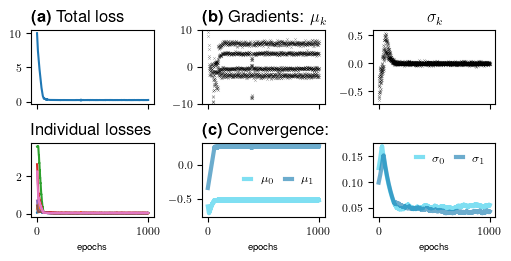

In [11]:
diagnostics_binom(path, file, save_fig = False)

### Learned prior distributions

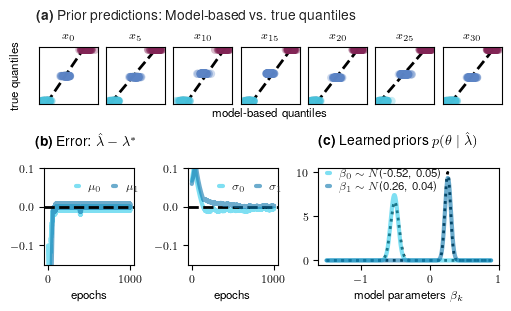

In [12]:
learned_prior_binom(path, file, selected_obs, true_values, 
                    last_vals = 30, save_fig = False)

### Summary output

In [3]:
from setup.write_results import model_summary
import pandas as pd

# get global dictionary
global_dict = pd.read_pickle(path+file+"/global_dict.pkl")

# print summary of method specifications
model_summary(path+file, global_dict)

General summary
---------------- 
method=parametric_prior
sim_id=binom_34764831
seed=34764831
B=128
rep=300
epochs=1000
wall time=28:85 (min:sec)
optimizer=<class 'keras.src.optimizers.adam.Adam'>
learning rate={'lr_scheduler': <keras.src.optimizers.schedules.learning_rate_schedule.CosineDecayRestarts object at 0x000001BE7014ED00>, 'init_lr': 0.01, 'decay_steps': 50}

Model info
---------------- 
model name=<class 'user_input.generative_models.GenerativeBinomialModel'>
model parameters=['b0', 'b1']

Parametric Prior
---------------- 
distribution family={'b0': 'Normal_log_scale', 'b1': 'Normal_log_scale'}
initialization={'mu0': {'loc': 0.0, 'scale': 1.0, 'name': 'Normal'}, 'log_sigma0': {'low': -2.0, 'high': -3.0, 'name': 'Uniform'}, 'mu1': {'loc': 0.0, 'scale': 1.0, 'name': 'Normal'}, 'log_sigma1': {'low': -2.0, 'high': -3.0, 'name': 'Uniform'}}

Target quantities and elicitation techniques
--------------------- 

  target quantities elicitation technique combine-loss
0             yp